<center>
    
## <font color='blue'> ASTR 21100/31200
    
<center>
    
## <font color='blue'> Homework Assignment 4
    
<center>    
    
## <font color='blue'> Approximating 2D function using interpolation and regression
    
<center>
    
## <font color='blue'> Implementing Differential Evolution algorithm
    
<center>
    
## <font color='blue'> undergraduate students (35 points + 15 extra-credit)
    
<center>   
    
### <font color='blue'> Distributed: Friday, April 22
    
<center>
    
### <font color='blue'> Due: Friday, Apr 29, 9pm
    
<center>
    
#### <font color='black'> Humza Qureshi (hqureshi)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
import astropy.units as u
import scipy.interpolate
import scipy.optimize
from scipy import stats

def plot_pretty(dpi=200,fontsize=10):
    plt.rcParams['figure.dpi']= dpi
    plt.rc("savefig", dpi=dpi)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in')
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5)
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5)
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [2., 2.])
    plt.rc('legend',fontsize=5)
    plt.rcParams['figure.figsize'] = [5, 3]

plot_pretty()

## <font color='blue'>Exercise 1 (10 points): constructing optimal approximation for $d_L(\Omega_{\rm m0},\Omega_\Lambda)$</font>
**Background.** In the past two weeks you learned how to compute of the luminosity distance $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$. You also learned that this computation is sufficiently computationally expensive that would make it prohibitively expensive if we needed to evaluate it million or so times. The need to do so arises in statistical analyses when we try to find the best combination of $M$, $\Omega_{\rm m0}$, $\Omega_\Lambda$ that describe supernovae measurements or when we need to sample the range of these parameters  MCMC sampling that we will discuss next. 

This motivates constructing accurate approximations for $d_L(z,H_0,\Omega_{\rm m0},\Omega_\Lambda)$ using methods that we've been discussing in the last couple of classes (interpolation or regression). $d_L$ is a function of 4 parameters, but we do not need to construct approximation as a function of the Hubble constant $H_0$. This is because $d_L$ is proportional to $c/H_0$ and this is the only place where $H_0$ appears in its expression. Thus, if we tabulate $\tilde{d}_L(z,\Omega_{\rm m0},\Omega_\Lambda)=d_L/(c/H_0)$, we can always then compute the actual value of the luminosity distance $d_L=c/H_0\,\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$. 


**Goal of the exercise.** The goal of this exercise is for you to find an optimal approximation of $\tilde{d}_L$ (i.e. $d_L$ without $c/H_0$ factor) as a function of $\Omega_{\rm m0}$ and $\Omega_\Lambda$ (that is approximation should be two-dimensional, not two separate 1d approximations as a function of $\Omega_{\rm m0}$ and $\Omega_\Lambda$) for a given single value of $z$. 

"Optimal" here means that provides target accuracy of the approximation with the smallest training set of tabulated function values. Suppose our target fractional accuracy for $\tilde{d}_L$ is $<10^{-4}$. Experiment with 2D polynomial and 2D piecewise spline interpolation for $\tilde{d}_L$ with different number of training points using codes provided below and examples from the notebook [08_multid_optimization_class](https://drive.google.com/file/d/1-ptIvIvbRqtObk8x09ausJanXcqL8pJ0/view?usp=sharing). 

In [3]:
def d_l_tilde_astropy(z, H0, Om0, OmL, clight=2.99792e5):
    '''
    compute d_l_tilde using AstroPy d_L function

    Parameters:

    z - float, or numpy array, redshift
    H0 - float, Hubble constant in km/s/Mpc
    Om0, OmL - floats, dimensionless matter and dark energy densities

    Returns:

        d_L - float, or numpy array, rescaled by c/H0 in Mpc
    '''
    cosmo = LambdaCDM(H0=H0, Om0=Om0, Ode0=OmL)

    return cosmo.luminosity_distance(z=z) / u.Mpc / (clight/H0)

def get_dl_train_test(ntrain=15, ntest=100, z=1.0, H0=70.,
                      om0min=0., om0max = 1., omlmin=0., omlmax=1., spacing=np.linspace):

    om0tr = spacing(om0min, om0max, ntrain)
    omltr = spacing(omlmin, omlmax, ntrain)

    dl_train = np.zeros((ntrain, ntrain)) # initialize 2D numpy array for 2D grid of d_L values
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0tr):
        for j, omld in enumerate(omltr):
                dl_train[i,j] = d_l_tilde_astropy(z, H0, omd, omld)

    # test points
    om0t = np.linspace(om0min, om0max, ntest)
    omlt = np.linspace(omlmin, omlmax, ntest)

    dl_test = np.zeros((ntest, ntest)) # initialize 2D numpy array for 2D grid of d_L values
    # Now cycle through Om0 and OmL values, compute d_L and fill the dlgrid array with values
    for i, omd in enumerate(om0t):
        for j, omld in enumerate(omlt):
                dl_test[i,j] = d_l_tilde_astropy(z, H0, omd, omld)

    return om0tr, omltr, om0t, omlt, dl_train, dl_test

In [4]:
def chebyshev_nodes1(a, b, N):
    return (a + 0.5*(b-a)*(1. + np.cos((2.*np.arange(N)+1)*np.pi/(2.*(N+1)))))[::-1]

def chebyshev_nodes2(a, b, N):
    return (a + 0.5*(b-a)*(1. + np.cos(np.arange(N)*np.pi/N)))[::-1]

def polyfit2d(xtr, ytr, ftr, order=None):
    '''
    Parameters:
        xtr, ytr - 1d numpy vectors with training points of x and y
        ftr - function values at xtr, ytr values
        order - int, order of the polynomial

    Returns:
        coefficients of the 2D polynomial
    '''
    # generate 2d coordinates on a rectangular grid
    x, y = np.meshgrid(xtr, ytr)
    # coefficient array, up to x^kx, y^ky
    coeffs = np.ones((order+1, order+1))
    # array that will contain polynomial term values
    s = np.zeros((coeffs.size, x.size))

    # construct the 2D matrix of values for each polynomial term i, j
    for index, (j, i) in enumerate(np.ndindex(coeffs.shape)):
        # do not include powers greater than order
        if order is not None and i + j > order:
            arr = np.zeros_like(x)
        else:
            arr = x**i * y**j # coeffs[i, j] *
        s[index] = arr.flatten()

    # solve for the polynomial coefficients using least squares approximation of ftr values
    return np.linalg.lstsq(s.T, np.ravel(ftr), rcond=None)[0]

def poly2d(xtest, ytest, a):
    order1 = np.rint(a.size**0.5).astype(int)
    return np.polynomial.polynomial.polyval2d(xtest, ytest, a.reshape((order1,order1)))

class poly2dfunc:
    def __init__(self,a):
        self.a = a
        self.order1 = np.rint(a.size**0.5).astype(int)

    def __call__(self,xtest,ytest):
        return np.polynomial.polynomial.polyval2d(xtest, ytest, self.a.reshape((self.order1,self.order1)))

def train_model(ntrain=15, ntest=100, z=1.0, H0=70.,om0min=0., om0max = 1., omlmin=0., omlmax=1.,s=0,kx=3,ky=3,spacing=np.linspace,fit_type="spline",order=5):
    om0tr, omltr, om0t, omlt, dl_train, dl_test = get_dl_train_test(ntrain=ntrain, ntest=ntest, z=z, H0=H0, om0min=om0min, om0max=om0max, omlmin=omlmin, omlmax=omlmax, spacing=spacing)
    testing = {"om0t":om0t,"omlt":omlt,"dl_test":dl_test}
    if fit_type == "spline":
        return scipy.interpolate.RectBivariateSpline(om0tr, omltr, dl_train, s=s, kx=kx, ky=ky),testing
    elif fit_type == "poly":
        return poly2dfunc(polyfit2d(om0tr,omltr,dl_train,order=order)), testing

def get_frac_err(**kwargs):
    f,test_data = train_model(**kwargs)
    return f(test_data["om0t"],test_data["omlt"])/test_data["dl_test"] -1.

spacing = np.linspace
min_z = 0
max_z = 2
nzs = 10
ntrain_a = 37
ntrain_b = 100

frac_err_b = []
frac_err_a = []
zs = np.linspace(min_z,max_z,nzs+1)[1:]

for z in zs:
    frac_err_a.append(np.nanmax(get_frac_err(ntrain=ntrain_a,z=z,spacing=spacing,kx=5,ky=5,fit_type="spline")))

for z in zs:
    frac_err_b.append(np.nanmax(get_frac_err(ntrain=ntrain_b,z=z,spacing=spacing,kx=5,ky=5,fit_type="poly")))


**Task 1a. (4 points)**  Use functions above that generate 2D grids of d_L_tilde values. Try different numbers of training points along 1 dimension for the 2d spline approximation for $\tilde{d}_L$ for the ranges $\Omega_{\rm m0}=[0,1]$ and $\Omega_{\Lambda}=[0,1]$ and  find the minimal number of training points for which we can ensure the fractional error of $\tilde{d}_L$ $<10^{-4}$  for the entire range of $z\in [0,2]$. 

You should 

* Report the minimal number of training points that you find. 

* Present a calculation or a plot that demonstrates that fractional error is smaller than $10^{-4}$ for the entire range of  $z\in [0,2]$.

**Note:** There are several different SciPy routines that can be used for this.  I recommend using function <tt>scipy.interpolate.RectBivariateSpline(x, y, z, s=0, kx=3, ky=3)</tt>, where $z$ is the array of function values tabulated at training points in vectors $x$ and $y$, $s=0$ indicates interpolation (no smoothing), parameters <tt>kx=3, ky=3</tt> specify that cubic splines should be used in $x$ and $y$ variables. Example of using this function is shown below (you can read about other available options and see examples of how they are used <a href="https://mmas.github.io/interpolation-scipy">here</a>). Examples of how this function is used to construct 2D spline approximation is available in [08_multid_optimization_class](https://drive.google.com/file/d/1-ptIvIvbRqtObk8x09ausJanXcqL8pJ0/view?usp=sharing) notebook. 

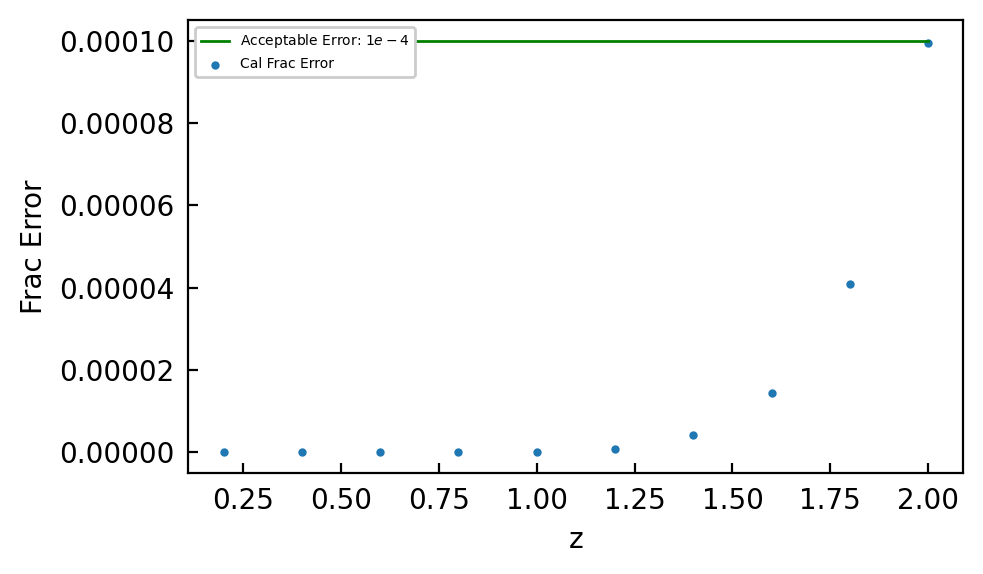

In [5]:
plt.plot(zs,[1e-4]*len(zs),label="Acceptable Error: $1e-4$",color="green",linewidth=1)
plt.scatter(zs,frac_err_a,s=4,label="Cal Frac Error")
plt.xlabel("z")
plt.ylabel("Frac Error")
plt.legend(loc = "upper left",framealpha=1)
plt.show()

**Task 1b (6 points).** Using functions <tt>polyfit2d</tt> and <tt>poly2d</tt> below construct 2D polynomial approximations of $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ for a given input single value of redshift $z$ and for ranges of the $\Omega_{\rm m0}$ and $\Omega_\Lambda)$ parameters of $\Omega_{\rm m0}\in [0,1]$ and $\Omega_\Lambda\in[0,1]$. 

Try different number of training points and polynomial order and try to find the minimal number and order that ensures the target fractional accuracy of $<10^{-4}$ for any $z$ in the interval $z\in [0,2]$. 

You should:

* Report the minimal number of training points that you find. 

* Present a calculation or a plot that demonstrates that fractional error is smaller than $10^{-4}$ for the entire range of  $z\in [0,2]$.


Based on the results of 1a and 1b, state your conclusions about the optimal method for approximating $\tilde{d}_L(z,\Omega_{\rm m0}, \Omega_\Lambda)$ with this target accuracy. 

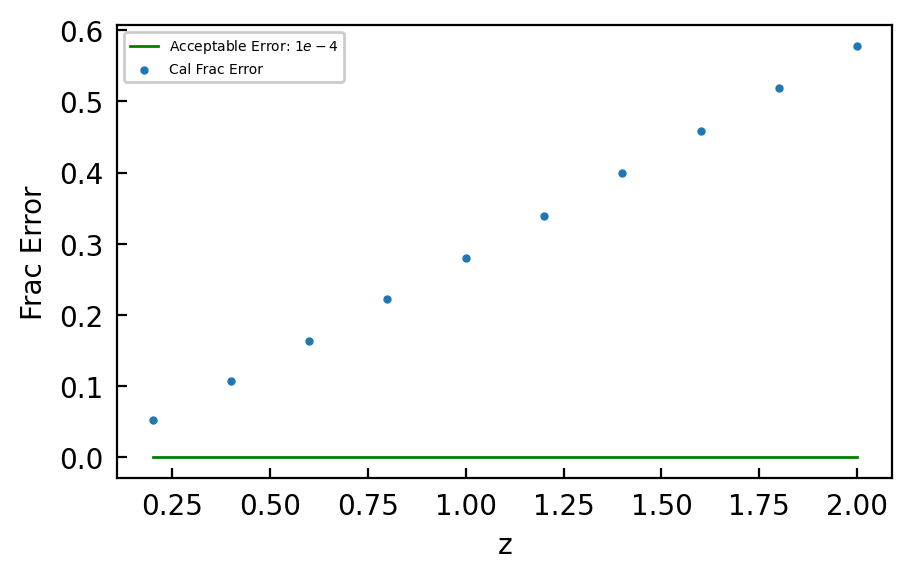

In [6]:
plt.plot(zs,[1e-4]*len(zs),label="Acceptable Error: $1e-4$",color="green",linewidth=1)
plt.scatter(zs,frac_err_b,s=4,label="Cal Frac Error")
plt.xlabel("z")
plt.ylabel("Frac Error")
plt.legend(loc = "upper left",framealpha=1)
plt.show()

## <font color='blue'>Exercise 2: implementing and testing  Differential Evolution algorithm for minimization (25 points + 5 extra-credit points)</font>

**Background.** Minimization in many dimensions is generally a complicated task. However, a class of <a href="https://en.wikipedia.org/wiki/Differential_evolution">Differential Evolution</a> (DE) algorithms developed from the initial ideas of R. Storn and K. Price in 1997 (<a href="https://link.springer.com/article/10.1023%2FA%3A1008202821328">Storn & Price 1997</a>), are relatively simple to implement, work in arbitrary number of dimensions, do not require function derivatives, allow imposing bounds on the domain, and are quite efficient in minimizing multi-dimensional functions.

### <font color='blue'>What you are learning in this exercise:</font>

* how to implement a general multi-dimensional minimization DE algorithm
* how to find minimum of a function in practice. 

**Task 2a. (20 points)** Use pseudo-code of the DE algorithm above to implement DE minimization function with the following interface (15 points):

    def minimize_de(func, x0, atol=1.e-6, s=0.1, bounds=None):
        """
        Parameters:
        ------------
        func - Python function object
               function to minimize, should expect x0 as a parameter vector
        x0   - vector of real numbers of shape (npop, nd), 
                where npop is population size and nd is the number of func parameters
        atol - float
                absolute tolerance threshold for change of population member positions
        s    - float 
               s parameter for scaling steps, the step size will be dwarf from uniform distribution between s and 1
        bounds - array of tuples 
                bounds for the minimization exploration; define the region in which to search for the minimum
        """
                

***Note:*** guard against for the cases when the small number of population members is used when population does not move at a given mutation stage, so that this does not result in premature stopping of the algorithm. 

***Note:*** Try to "vectorize" as much of the algorithm as possible. This code can be fully vectorized with only one loop for the mutations of the population. 


In [7]:
def rosenbrock(x):
    """The Rosenbrock "banana" function
    x is a vector of points in 2 or more dimensional space
    """
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def minimize_de(func=rosenbrock, x0=None, atol=1.e-6, s=0, smin=None, bounds=None):
    assert type(x0) is not None
    npop = x0.shape[0]
    nd = x0.shape[1]
    xnow = np.copy(x0)
    fnow = np.empty(npop)
    for i in range(npop):
        fnow[i] = func(xnow[i])
    xnext = np.zeros_like(xnow)
    has_bounds = True
    if isinstance(bounds, type(None)):
        has_bounds = False
    else:
        bounds = bounds.T
        bounds[1] -= 1

    while True:
        inds = np.ma.arange(npop)
        delta = 0
        for i in range(npop):
            inds[i] = np.ma.masked
            while True:
                ir1,ir2,ir3 = np.random.choice(inds.compressed(),3,replace=False)
                inds.mask = np.ma.nomask
                if smin != None:
                    s = np.random.uniform(smin,1)
                xtry = xnow[ir3] + s * (xnow[ir1] - xnow[ir2])
                if has_bounds:
                    if np.all(np.logical_xor(*((xtry-bounds) > 0))):
                        break
                else:
                    break
            f_xtry = func(xtry)
            if f_xtry <= fnow[i]:
                temp_delta = np.abs(fnow[i] - f_xtry)
                xnext[i] = xtry
                fnow[i] = f_xtry
                if temp_delta > delta:
                    delta = temp_delta
            else:
                xnext[i] = xnow[i]
        xnow = np.copy(xnext)
        if delta < atol:
            break
    out = []
    for i in range(xnow.shape[1]):
        out.append(stats.mode(xnow[:,i])[0])
    return np.array(out).T[0]

def get_error(de_func=minimize_de,s=0,smin=0,npop=10,nd=2,bounds=np.array([(20,-20)]),known_minimum=np.array([1.,1.]),repeats=20):
    if nd != bounds.shape[0]:
        bounds = np.repeat(np.reshape(bounds[0],(1,bounds[0].shape[0])),nd,axis=0)
    high,low = np.repeat(bounds.T,npop,axis=1)
    avg_error = np.zeros(repeats,dtype=np.float64)
    for i in range(repeats):
        x0 = np.reshape(np.random.uniform(high=high,low=low),(npop,nd))
        minimum = de_func(x0 = x0,bounds = bounds,smin=smin,s=s)
        avg_error[i]=np.max(np.abs(minimum-known_minimum))
    return avg_error

def get_data(npops,repeats,verbose=True,**args):
    npops = np.array(npops)
    errors = np.zeros((len(npops),repeats))
    for idx,npop in enumerate(npops):
        if verbose:
            print(str(round((idx/len(npops))*100,1)) + "% done")
        errors[idx] = get_error(npop = npop, repeats = repeats, **args)
    return npops,errors

npops = (10**(np.linspace(1,2,5))).astype(int)
repeats = 20
R5s = {}
for smin in np.linspace(0,1,4):
    npops,errors = get_data(npops,repeats,known_minimum=np.array([1,1,1,1,1]),nd=5)
    R5s[smin] = (npops,errors)

R2s = {}
for smin in np.linspace(0,1,4):
    npops,errors = get_data(npops,repeats,known_minimum=np.array([1,1]),nd=2)
    R2s[smin] = (npops,errors)

C:\Users\Humza\AppData\Local\Temp/ipykernel_33828/1754978455.py:76: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  npops = (10**(np.linspace(1,2,5))).astype(np.int)


0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done
0.0% done
20.0% done
40.0% done
60.0% done
80.0% done


***Таск 2b (5 points).*** Test your implementation using Rosenbrock function implemented below in 2- and 5-dimensions. Try different number of population members and $s$ values and choices for how $s$ is chosen and examine how results change and for what number of population members the algorithm returns correct minimum value reliably ($[1,1]$ in 2D and $[1, 1, 1, 1, 1]$ in 5D). 

* Present a brief discussion of how large population should be in 2D and 5D to get correct minimum reliably. 

* Present a brief discussion of how choices of $s$ affect results 

* Demonstrate that your function returns values within the specified atol value reliably in 5D. 

* Compare results of your function to results of the <tt>scipy.optimize.differential_evolution</tt>

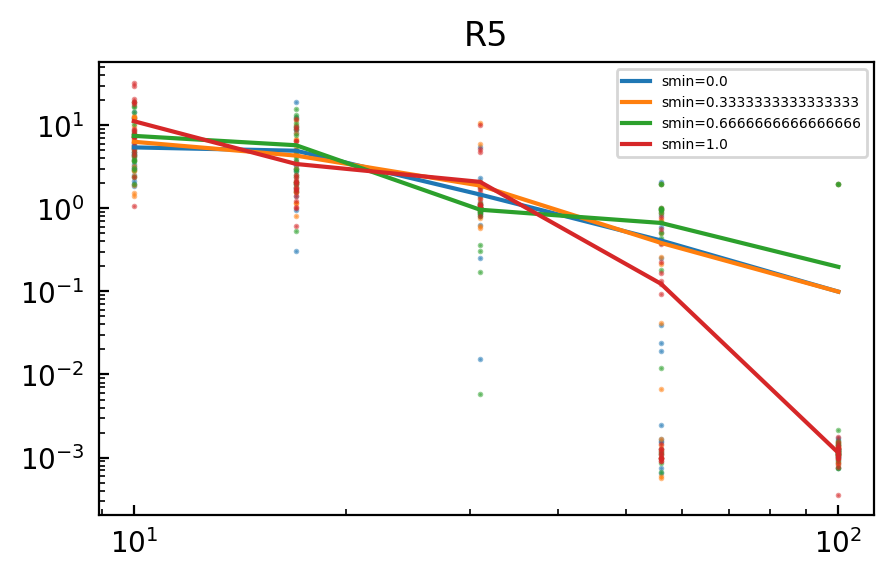

In [8]:
for smin in R5s.keys():
    npops,errors = R5s[smin]
    plt.scatter(np.repeat(npops,errors.shape[1]),errors.flatten(),s=1,alpha=0.5)
    plt.plot(npops,np.mean(errors,axis=1),label="smin="+str(smin))

plt.xscale('log')
plt.yscale('log')
plt.title("R5")
plt.legend()
plt.show()

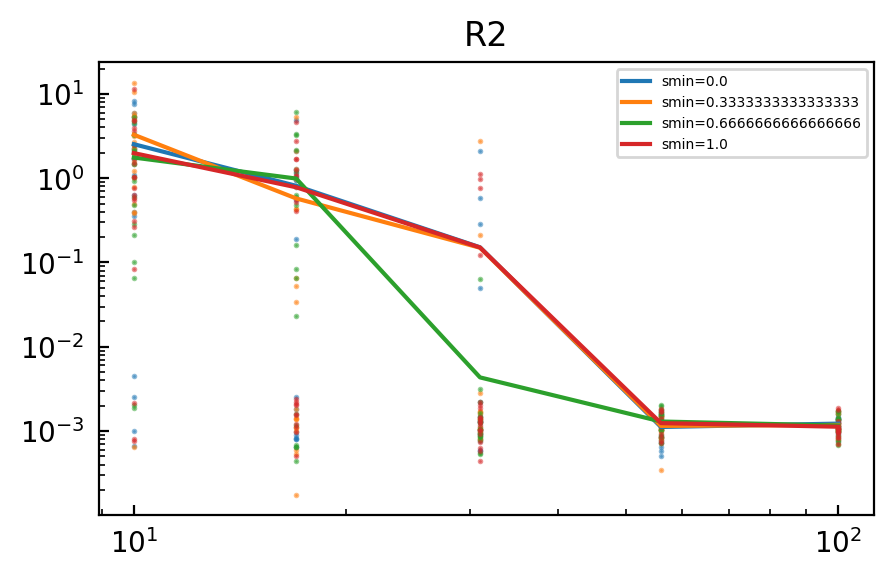

In [9]:
for smin in R2s.keys():
    npops,errors = R2s[smin]
    plt.scatter(np.repeat(npops,errors.shape[1]),errors.flatten(),s=1,alpha=0.5)
    plt.plot(npops,np.mean(errors,axis=1),label="smin="+str(smin))

plt.xscale('log')
plt.yscale('log')
plt.title("R2")
plt.legend()
plt.show()

In [23]:
x = scipy.optimize.differential_evolution(func=rosenbrock,bounds=np.array([[-20,20],[-20,20]]),popsize=10,atol=1.e-6,init='random')
print(np.max(np.abs((x.x)-np.array([1.,1.]))))

0.0008173416733794348
